## Introduction to several typical papers on Graph Pooling Methods

Recently two of my projects required a technique to coarsen a big graph into a smaller one, thus it's important to learn some techniques in this field. In this blog, I will introduce some papers briefly, these papers were mainly published in 2019-2022. I will share their basic ideas, how they work and why they are important. 

Most of them use the graph neural network technique and some of them are more like to be 'pure physics' work. 
<hr/>

### Why to coarsen a graph?
From the perspective of AI. There is an important task named 'Graph Classification'. In which we have to classify wheather a graph belong to some classes. For example, does a molcule have this perticular effects? or is this man(represented by a graph) running? To finish this task we have to get a representation of a graph. 

Traditionaly the graph neural networks are the architecture working on nodes and edges. They aggregate the node information by the topology and update the node representations thus they work well on tasks like node classifications or link predictions. One trivial way to get a graph representation from node representation is to simply add nodes feature together. Actually this method usually bring us farely good results. But there are some disadvantages of this method: This method ignored the importance of different nodes and the topology information while constructing a graph embedding vector.

Learning the hierarchical representations of a network can make the process of creating a graph embedding more refined. We don't come to the graph embedding directly but create a smaller network in each layer and gradually we got a network with only one node. That node embedding is the graph embedding.

From the perspective of network science, It's hard to calculate the properties of a network while the network is super large. For example, the spectral of the laplacian matrix of the network. Thus it's important to construct a smaller network who has the same characteristics as the original network.

<hr/>

### Basic Ideas for Hierarchical Pooling
#### Topology based hierarchical pooling

One typical idea to coarsen a graph is to use spectral clustering, by this method we can easily construct a macro network in which one node corresponds to a node cluster in the micro network. But this algorithms use eigendecomposition. Due to the time complexity we can not use this method in large networks.

#### Get hierarchical Representation by learning

Another way to get the macro network is by learning, we use a graph neural network to construct a new network from the original one. Actually in this direction there exist two different basic ideas. The first is to correspond the nodes in the macro network to the cliques in the micro network, and the other is to select some representative nodes in the micro network (and throw others away) to construct the macro network.

<hr/>

### Related Works

#### 《Converting high dimensional complex networks to lower dimensional ones preserving synchronization features》
<a href='https://iopscience.iop.org/article/10.1209/0295-5075/ac98de/meta'>link here</a>

Here is the motivation of this paper: Studying the stability of synchronization of coupled oscillators is important to network science, but due to the network size, it's costly to finish the complex network analysis especially when there are too many nodes. Thus it's important to create a similar but smaller network to analyze. I mean 'similar' here refers to keeping the synchronization features unchanged.

The basic idea to overcome this challenge is: they found that if the first, second, and last eigenvalue of the laplacian matrix of the smaller network is the same as the larger one, the problem is solved. At least it works well for Sportt-B oscillators. Thus this problem has been transformed to Create a network that has fixed first, second and last eigenvalues. The following figure shows how they create this smaller network.

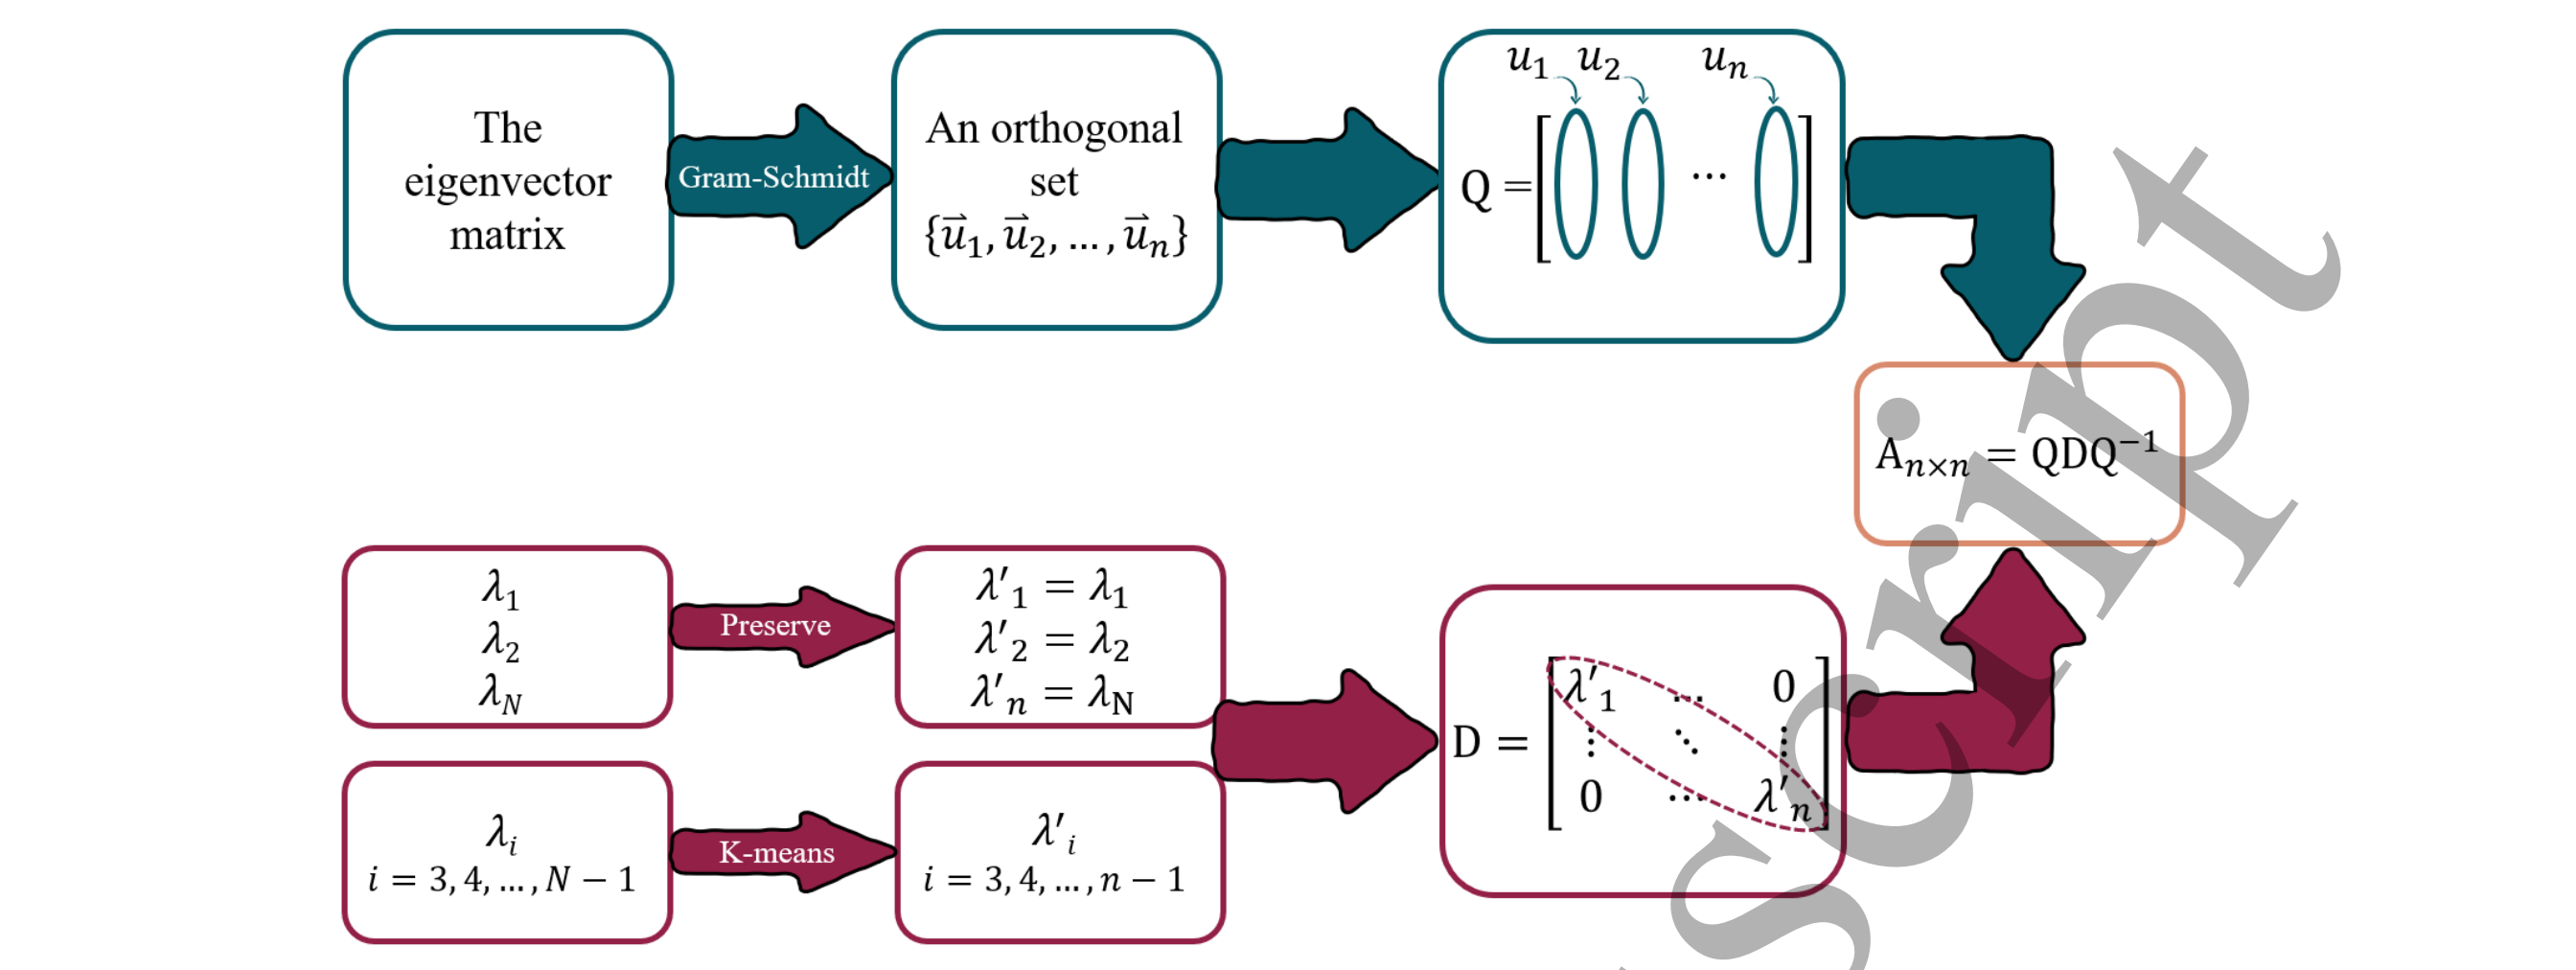

Let's first look at the red schematic process. In which $\lambda_1,\lambda_2$ and $\lambda_N$ is the first, second and last eigenvalues(sorted from the smallest to the largest) of the laplacian matrix of the larger netowrk, where $N$ is the node number of the larger network. Since we want to create a smaller network with $n$ nodes($n<<N$), this smaller netowrk should have $n$ eigenvalues $\lambda^\prime_1,\lambda^\prime_2,...,\lambda^\prime_n$. We preserve the first, second and last eigenvalues of the larger netowrk by letting $\lambda^\prime_1=\lambda_1$,$\lambda^\prime_2=\lambda_2$ and $\lambda^\prime_n=\lambda_N$. As for the rest of the $n-3$ eigenvalus of the smaller network, we run K-means method on $\lambda_3,\lambda_4,...,\lambda_{N-1}$ to get $n-3$ eigenvalus for the smaller network.

Since we got the eigenvalues, the eigenvectors are not difficult to obtain due to the following two facts: One is that eigenvectors of a laplacian matrix are orthogonal to each other. Another is the eigenvector corresponding to the first eigenvalue(which is 0) is $[1,1,..,1]_{1*n}$. By these facts. We can get all the eigenvectors by the Gram-Schmidt process.

With the eigenvectors and eigenvalues, we can construct the laplacian matrix of the smaller network easily by simply multiplying them together. 

#### 《Spectral clustering with graph neural networks for graph pooling》
<a href='https://arxiv.org/abs/1907.00481'>link here</a>

The last paper was cool but there is still one important limitation: the eigendecomposition of the Laplacian is expensive. In this paper, we will introduce a Graph Neural Network based method that formulate a continuous relaxation of the spectral clustering problem. By GNN, We don't need the eigendecomposition of the matrix, we learn a grouping matrix by GNN to cluster the nodes of the large network. The clustering result is similar to the spectral clustering algorithm, which satisfies the properties of dense edge connections within the same cluster and sparse edge connections between different clusters.

The basic idea is to construct an assignment matrix $S_{N*K}$($K$ is a hyper parameter we can change, it means the number of clusters) to decide which node belongs to which cluster. If $S$ was obtained, we can coarsen the adjacency by $A^{pool} = S^T\hat{A}S$.It is worth noting that $A^{pool}$ is a symmetric matrix, whose entries $A^{pool}_{i,j}$ indicate the weighted sum of edges between cluster $i$ and $j$. Features of each cluster can be calculated by $X^{pool} = S^TX$, $X^{pool}_i$ is the feature of cluster $i$, and its sum of the node features in cluster $i$.

But how to get a good grouping matrix $S$? Here is the key question of this paper. They believe $S$ should be decided by node features and the topology, thus this model can be trained once and be utilized for a lot of graphs with the same data distribution. So they use one layer GNN with the following MLP to decide which cluster one node belongs to.

The loss function is a little bit confusing. The first item of the loss function, $L_c$, looks like this:

$L_c = -\frac{Tr(S^T\hat{A}S)}{Tr(S^T\hat{D}S)}$

The second item in the loss function is:

$L_o = ||\frac{S^TS}{||S^TS||_F}-\frac{I_K}{\sqrt{K}}||$

And the finall loss $L_i$ is:

$L_u = L_c+L_o$

Let me explain what $L_c$ and $L_o$ mean. First, let's see $L_c$, essentially this term encourages strongly connected nodes to be clusterd together, let me explain why: The denominator $Tr(S^T\hat{D}S$ looks confusing but it essentially means the sum of the degrees of the nodes in the original bigger graph(# of edges in the larger graph). So it doesn't change with $S$. The numerator indicates the sum of the number of neighbors of each node within its cluster. If the graph was perfectly cut, I use 'perfectly' here means that there are no edges between different clusters. Then the number of the neighbor of one node in its cluster is equal to its degree so the numerator is equal to the denominator and we got the minimum of the $L_c$: -1. 

As for the second term $L_o$, it encourages the clusters to be of similar size: no super big cluster and no super small cluster. $S^TS$ is a diagonal matrix where each element means the number of nodes in that cluster, and the denominator can be viewed as a normalizing term. The more similar the number of each cluster the better.


As we can see, This model can be trained in an unsupervised way, It achieves a similar result with spectral clustering with an acceptable space and time complexity. It's a brilliant work, no wonder it was chosen by ICML2020.

#### 《Self-attention graph pooling》

<a href='https://arxiv.org/abs/1904.08082'>link here</a>


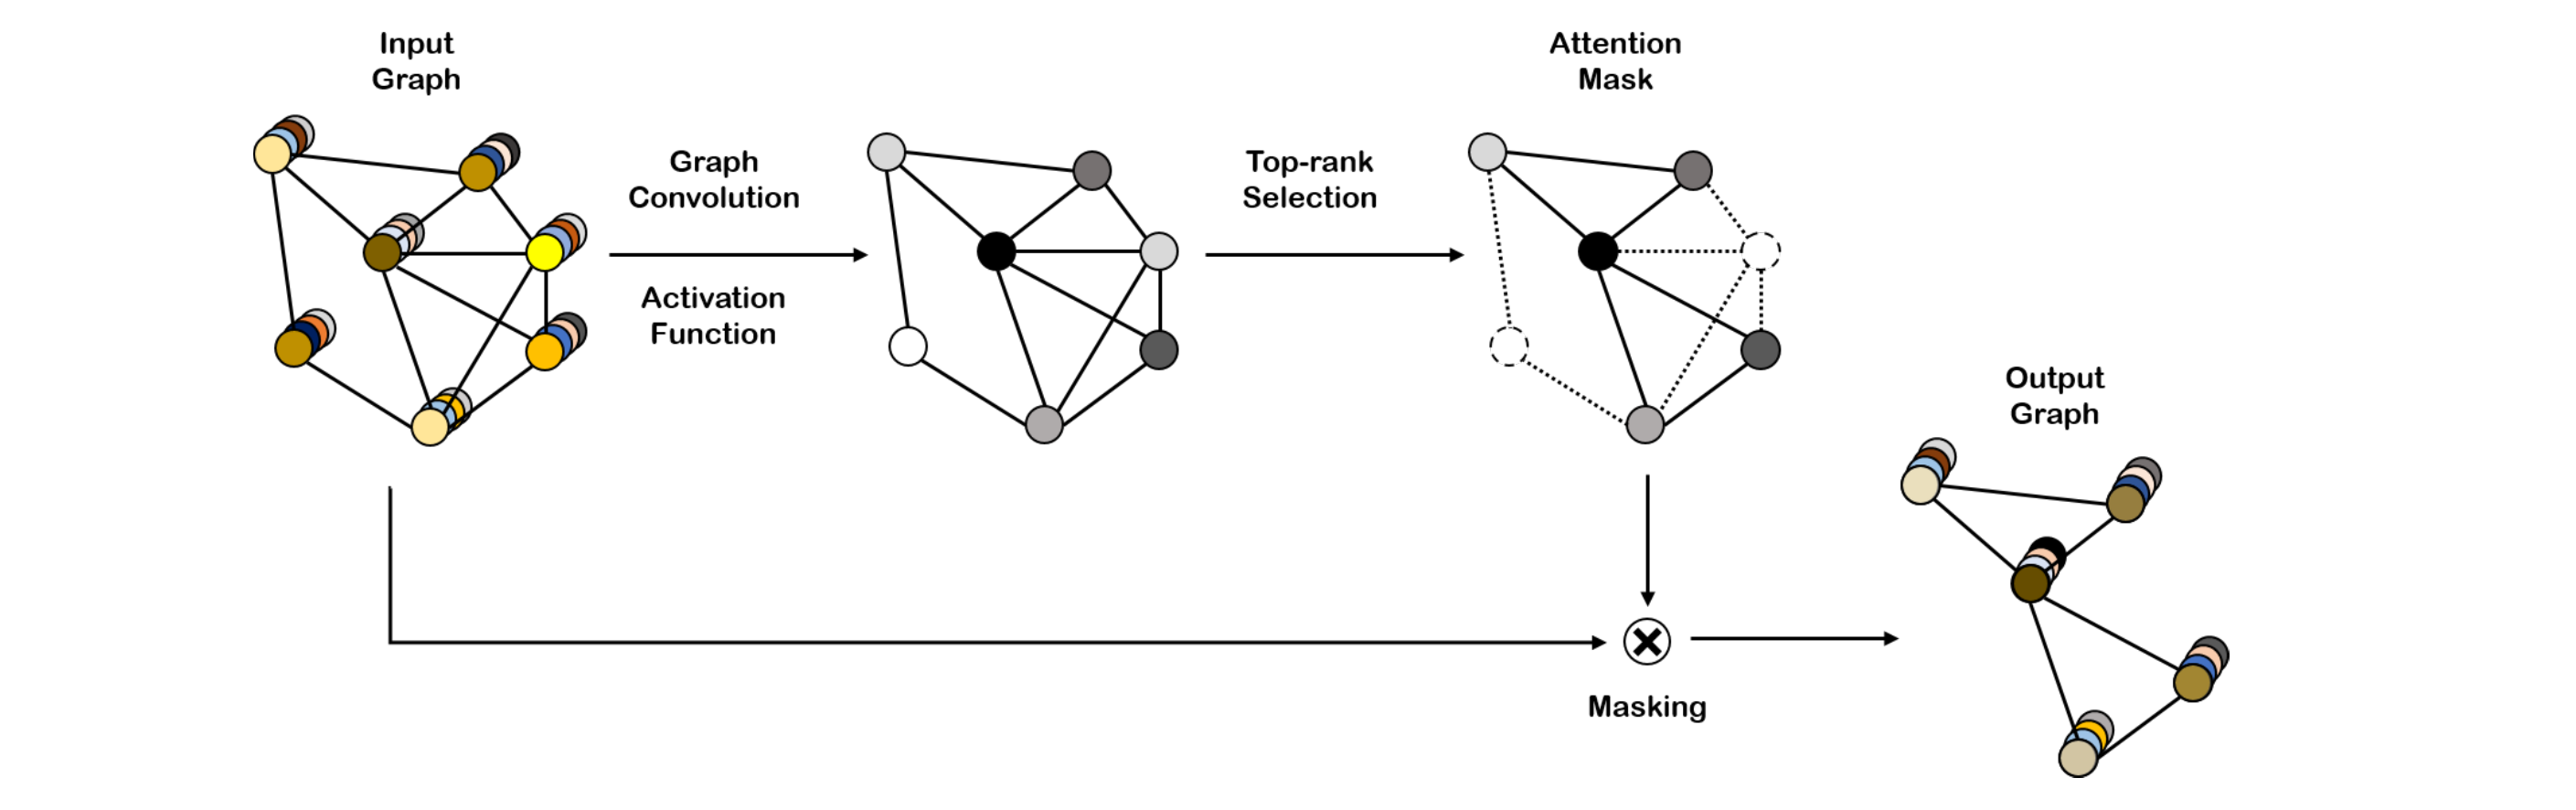

Here is what happened in Self-Attention Graph(SAG) Pooling process. In this process, they create a smaller network from the original one. I have to point out two key differences between this work and the previous two:

- In each time they conduct graph pooling, they do not assign nodes to clusters, otherwise, they choose representative nodes and drop out the other nodes.
- The whole architecture is used for the graph classification task, which means that there is no prior knowledge in this process. We do not encourage the machine to choose representative nodes with any bias, everything is done by the machine itself. Thus this architecture is flexible.

Now let's talk about some details about this architecture. The key questions are how to decide which node to choose and which node to throw. And with the selected nodes, how do we construct a new smaller network? 

To answer the first question, We conduct a GNN to form one-dimensional information for each node, that information can be viewed as the rank score. Actually, it's pretty flexible here, we can use one-layer GCN, two-layer GCN, or other GNN architectures of interest.

And it's easy to answer the second question: if we remove some nodes, the corresponding edges are removed, so the network with remaining nodes and edges is the network in the next level.

Another innovation of this paper is that at each hierarchy a global feature is obtained using the readout method. These features are added together for graph classification. See this in the following figure:

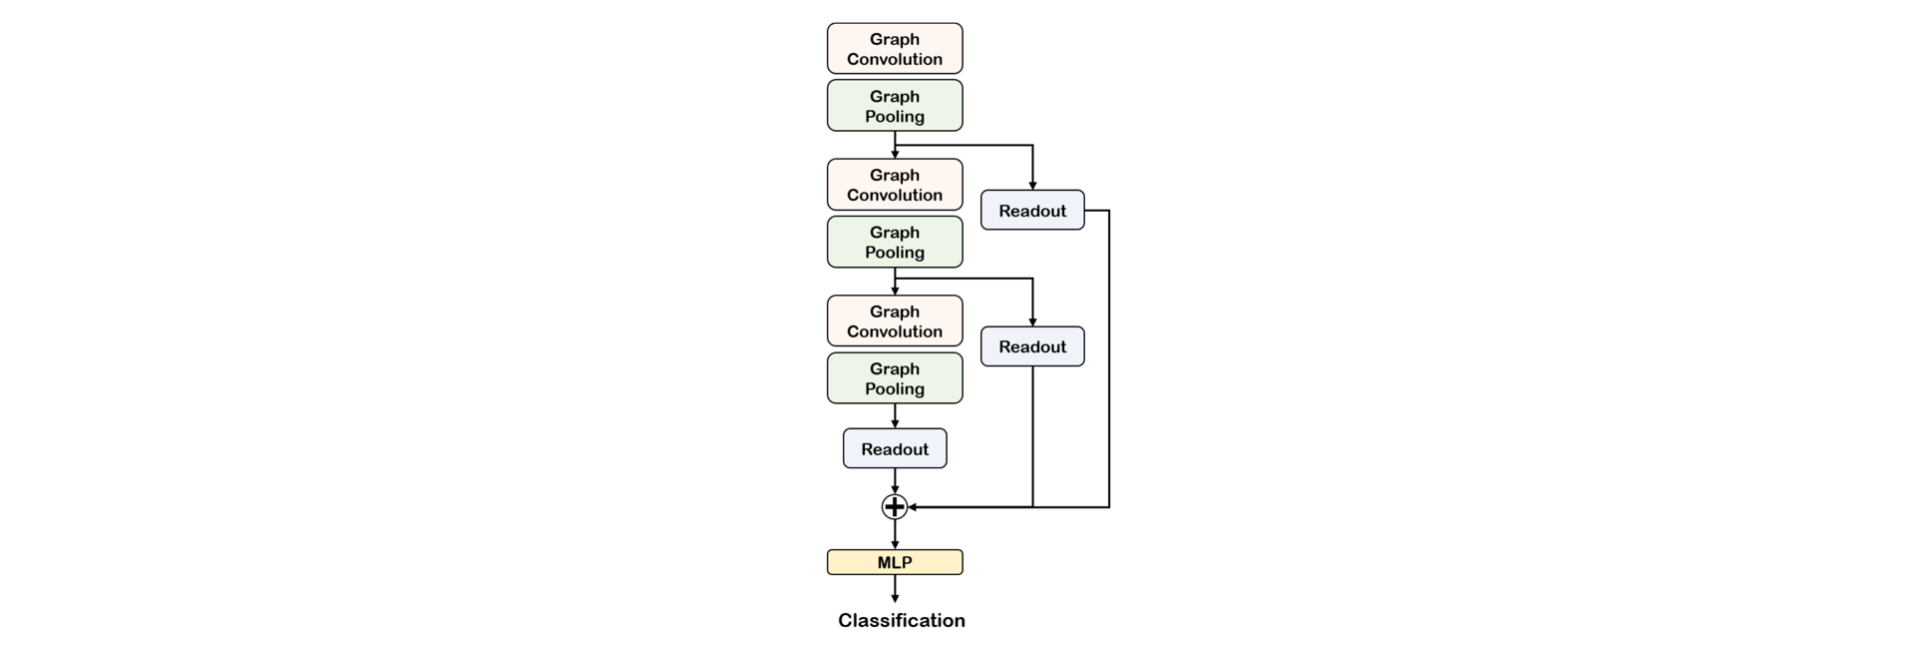

The readout layer works as follows:

$s = \frac{1}{N}\sum_{i=1}^Nx_i||\max_{i=1}^NX_i$

where $N$ is the number of nodes, $X_i$ is the feature vector of i-th node, and || denotes concatenation.

#### 《Hierarchical Graph Pooling with Structure Learning》
<a href='https://arxiv.org/abs/1911.05954'> link here </a>


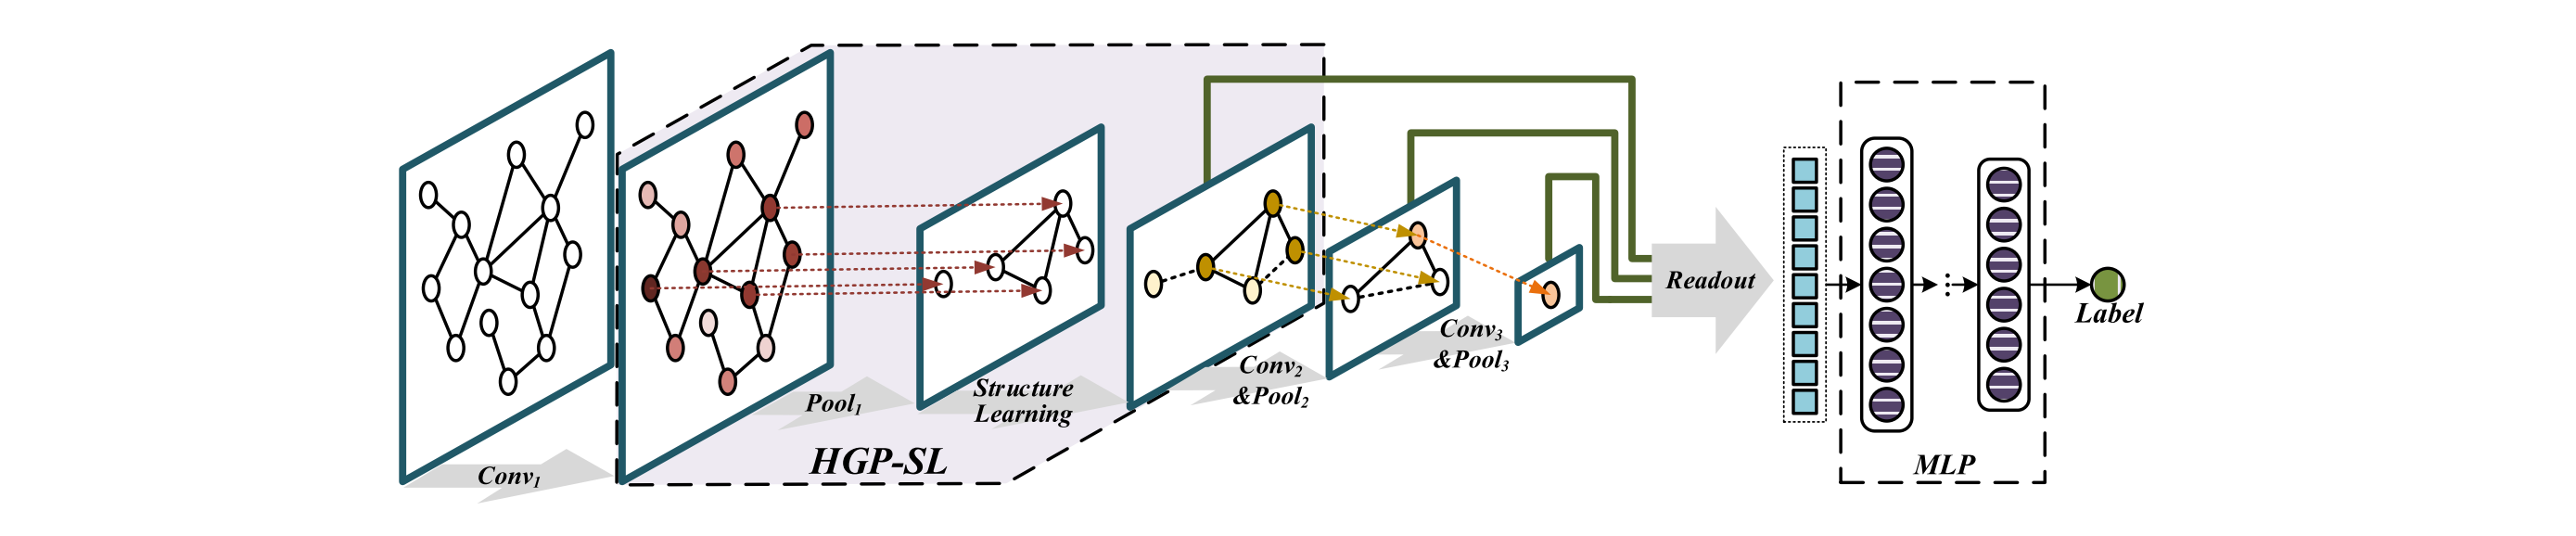

From this figure, we can see that the architecture in this paper is roughly the same as the previous one. We choose some representative nodes and throw others away to form a smaller network. The final objective is also the same: node classification tasks.

But there are two key differences between these two papers, they are:
- They use different methods to choose the remaining nodes. 
- They use different methods to form a new topology.

I will show what method this paper use to choose representative nodes and how they construct a new topology at a new level.

In the previous paper, They choose representative nodes without any inductive bias, but in this paper, they have some principles to choose a node, they believe that if a node's representation can be reconstructed by its neighborhood representations, it means this node can probabily be deleted in the pooled graph with almost no information loss.

So they define metric called node information score as the distance between the node feature and the mean of it's neighbors features:

$p=||(I-D^{-1}A)H||_1$

where $||.||_1$ performs $l_1$ norm, $A$ is the adjacency matrix and $D$ means the diagonal degree matrix of $A$. It's easy to see that $p$ encode the information score of each node in the graph.

With the node information score, we can choose the nodes with the top-scores and throw other nodes away, but as for structure, if we just ignore all edges connected with deleted nodes(just like previous paper did), the network will soon become disconnected. So they proposed a structure learning mechanism. This mechanism can be expressed as:

$E(p,q) = \sigma(\overrightarrow{a}[H(p,:)||H(q,:)]^T+\lambda * A(p,q))$

Where $E(p,q)$ is the score of a candidate edge, $H(p,:)$ is essentially the representation of node $p$,  $\overrightarrow{a}$ is a learnable vector and $A(p,q) = 1$ if node $p$ and $q$ are directly connected.  This is essentially measure wheather node $p$ and node $q$ should be connected. if they are alreadly connected, then it's easy to get a high $E(p,q)$.

With These scores for each possible edge, they use a sparsemax function(which is similar to softmax function but with less non-zero values) to normalize the weight to get a row-normalized matrix as the adjacency matrix in next level.



#### 《Rethinking pooling in graph neural networks》
<a href='https://proceedings.neurips.cc/paper/2020/hash/1764183ef03fc7324eb58c3842bd9a57-Abstract.html'>link here</a>

This is a NerrIPS 2020 paper. From its title, we can see that this paper doesn't propose another graph pooling method but investigated some properties of the existing graph pooling methods. This paper is important because it tells us that under most conditions, graph pooling with clustering is not important at all, which inspired me a lot.

Let's see an experiment first: In this experiment, they test the performance of two different graph pooling models for graph classification tasks in different datasets. The graph pooling methods they used here are pure structural-based methods and it doesn't matter with node embeddings.

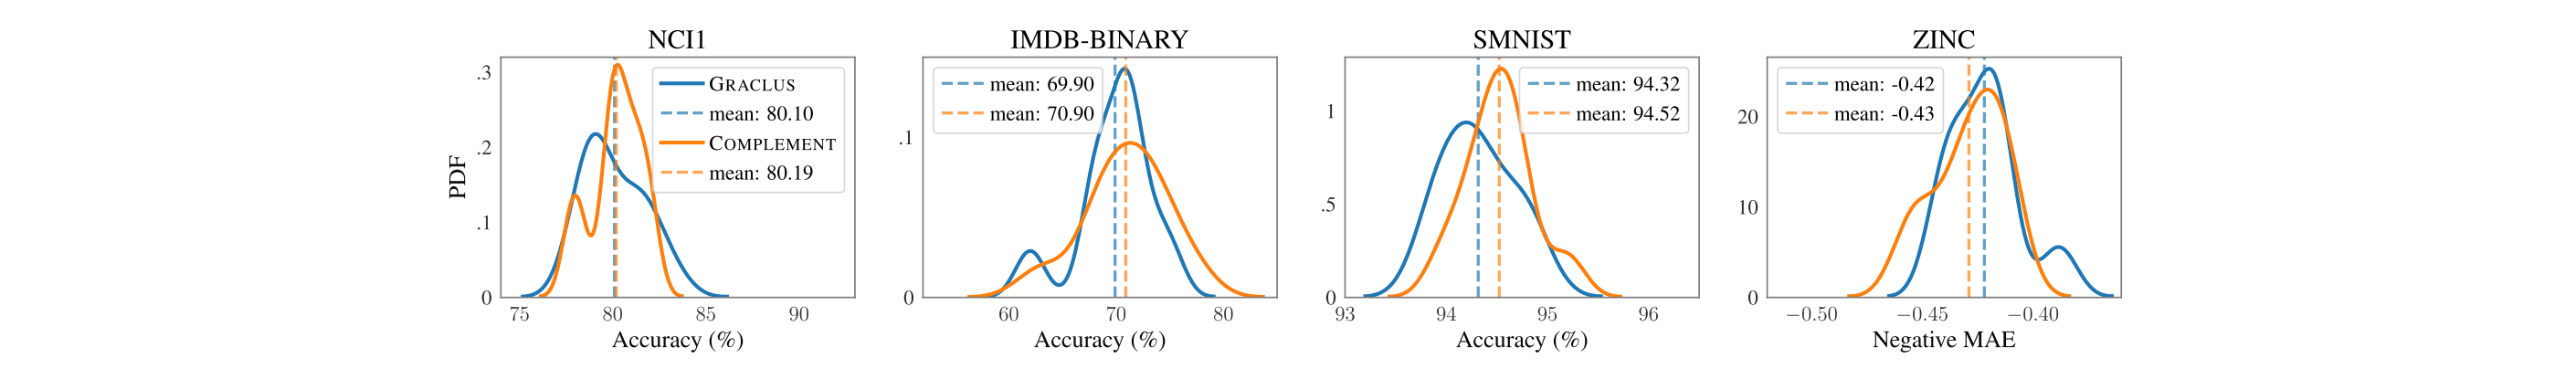

In this figure there exist four subplots, each of which is a different dataset. The x-axis is 'accuracy' and the y-axis is 'PDF' meaning each subplot is the accuracy distribution. The blue solid blue line means the accuracy distribution for the graph pooling method 'GRACLUS' on the graph classification task and the yellow solid line for 'COMPLEMENT'. 

'GRACLUS' method is a pure structural-based pooling method aiming to cluster connected nodes together [1]. And the 'COMPLEMENT' is the opposite: we try to cluster disconnected nodes together by run the 'GRACLUS' method on a complement graph. 

The result is counter-intuitive: There is no big difference between these two pooling methods. Some times 'COMPLEMENT' method even perform better than 'GRACLUS'. The only explanation seems to be that the pooling operation is not important at all. 

They also conducted similar experiments: The next figure shows different pooling methods for the well-known DiffPool[2] paper. Originally, the DiffPool method learns an assignment matrix that decides which node belongs to which cluster. But in this experiment, they replace the assignment matrix with a softmax on a normalized random matrix. They consider three different distributions for the random matrix: Uniform, Normal, and Bernoulli. 

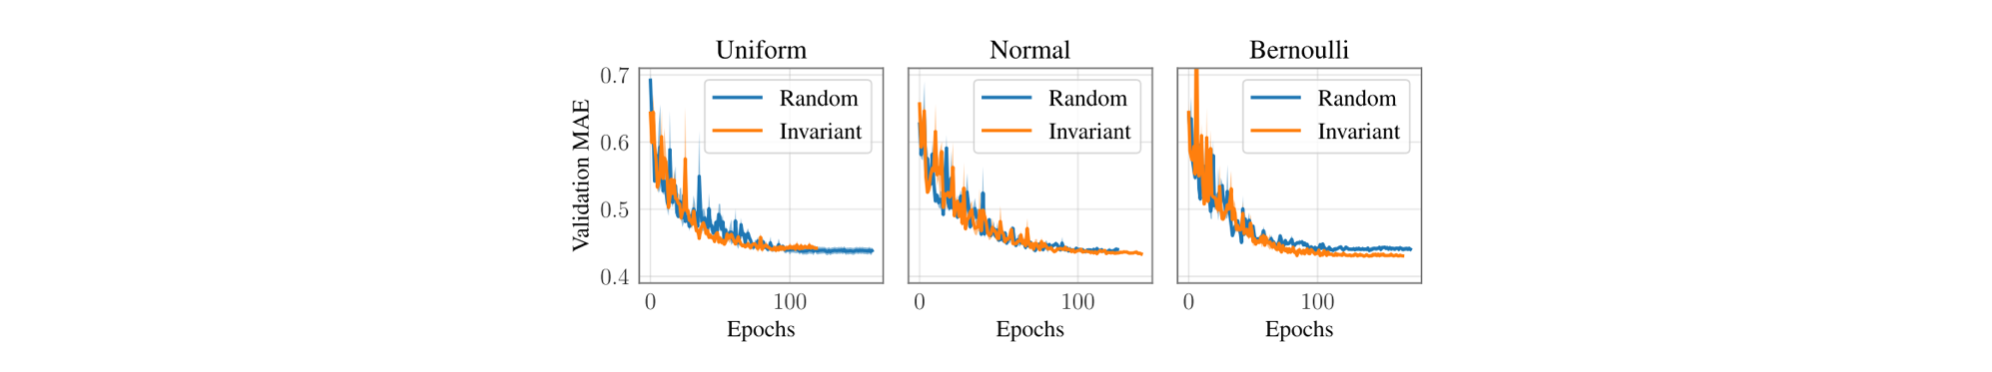

Again, we find that a random pooling mechanism achieves comparable results to its counterpart.

But why, They offered a possible explanation: The node's representation is over-smoothing: every node looks the same, so it doesn't matter if you combine who of them together. To valid this assumption, They conduct another experiment in which they replace the default GNN model with a simpler one with a weak expressiveness(which is red in the following table) and check the accuracy of graph classification tasks.

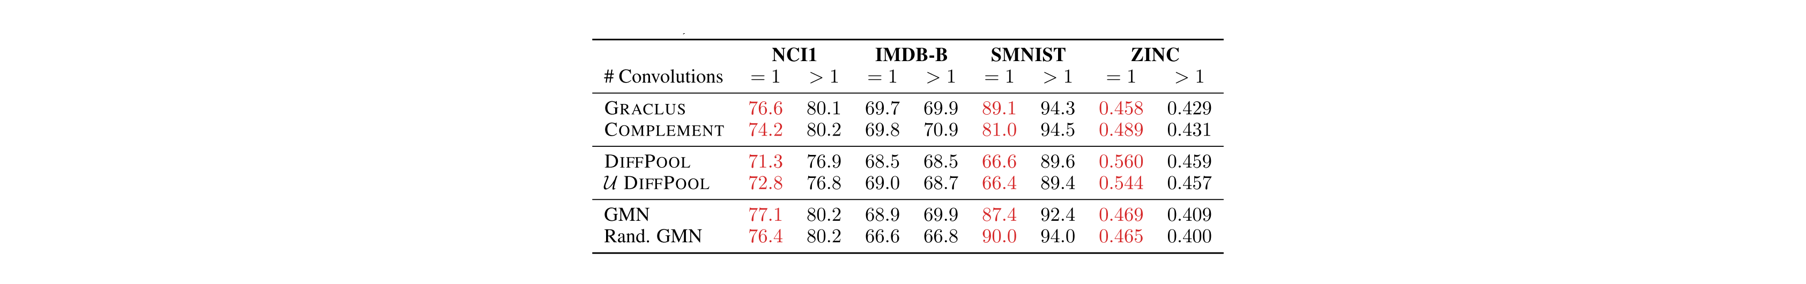

In this table '=1' means a simpler GNN with a weak expressive power and '>1' means the default GNN with strong expressive power. Different columns means differnet datasets. First, we can see that all red numbers are smaller than their counterpart, which means the expresiive power limit the accuracy of the graph classification tasks, and another thing we can see is that 'GRACLUS' is better than 'COMPLEMENT', 'DIFFPOOL' is better than 'U DIFFPOOL'. 

So the conclusion is that the default graph pooling method is indeed effective, but only when the GNN is too simple, when the GNN is very powerful, it will generate an overly smooth node representation, causing the default pooling method to fail.

[1] I. S. Dhillon, Y. Guan, and B. Kulis. Weighted graph cuts without eigenvectors: a multilevel approach. IEEE Transactions on Pattern Analysis and Machine Intelligence, 29(11):1944–1957, 2007.

[2] Z. Ying, J. You, C. Morris, X. Ren, W. Hamilton, and J. Leskovec. Hierarchical graph representation learning with differentiable pooling. In Advances in Neural Information Processing Systems (NeurIPS), 2018.
